In [64]:
from pathlib import Path
import re
import sys

import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
from tqdm import tqdm_notebook

%matplotlib inline
sns.set_style("darkgrid")
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
set_matplotlib_formats('png')

%load_ext autoreload
%autoreload 2
sys.path.append("../src")
import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data preparation

In [4]:
# Path to decoder results
decoder_path = Path("../models/decoders")
bert_encoding_path = Path("../models/bert")

In [23]:
# Path to BERT directory, containing model checkpoints
bert_path = Path("~/om2/others/bert").expanduser()
# Base model used as init checkpoint for finetuning
bert_base_model = "uncased_L-12_H-768_A-12"
# Fine-tuning tasks / models
bert_models = ["_", "SQuAD", "QQP", "MNLI", "SST", "LM", "LM_lmonly", "LM_scrambled", "LM_lmonly_scrambled", "LM_contentonly", "LM_contentonly_scrambled", "LM_randommask", "LM_pos"]
# Comparison models (not fine-tuned)
other_models = ["glove"]
# Models which should appear in the final report figures
report_models = ["SQuAD", "QQP", "MNLI", "SST", "LM", "LM_scrambled", "LM_pos"]
checkpoint_steps = list(range(5,255,5))
# Describes the particular fine-tuning regime used
finetune_desc = "finetune-250"
target_runs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [6]:
RENDER_FINAL = False
figure_path = Path("../reports/figures")
figure_path.mkdir(exist_ok=True)

# Decoding analyses

We first aggregate and plot mean-average-rank statistics for each decoder.

In [19]:
# Decoders for fine-tuned BERT models
decoding_perfs = util.load_decoding_perfs(decoder_path,
                                          glob_prefix="encodings.%s.*-%i-" % (finetune_desc, checkpoint_steps[-1]))

Loading perf files: 100%|██████████| 712/712 [00:01<00:00, 456.95it/s]


In [22]:
# Load base decoder data.
base_perfs = {}
for base_decoder_perf_path in decoder_path.glob("encodings.%s*.csv" % bert_base_model):
    subject, = re.findall(r"-([\w\d]+)\.csv$", base_decoder_perf_path.name)
    perf = pd.read_csv(decoder_path / (base_decoder_perf_path.name.replace("pred.npy", "csv")),
                       usecols=["mse", "r2", "rank_median", "rank_mean", "rank_min", "rank_max"])
    base_perfs["_", 1, 0, subject] = perf
decoding_perfs = \
    pd.concat([decoding_perfs,
               pd.concat(base_perfs, names=["model", "run", "step", "subject"])])

In [27]:
# Load comparison model data.
for other_model in other_models:
    for other_perf_path in tqdm_notebook(decoder_path.glob("encodings.%s-*.csv" % other_model)):
        subject, = re.findall(r"-([\w\d]+)\.csv$", other_perf_path.name)
        perf = pd.read_csv(other_perf_path,
                           usecols=["mse", "r2", "rank_median", "rank_mean", "rank_min", "rank_max"])
        decoding_perfs.loc[other_model, 1, 0, subject] = perf.iloc[0]

In [28]:
decoding_perfs.tail()

mse        r2  rank_mean  rank_median  rank_min  \
model run step subject                                                         
glove 1   0    M08      0.003592 -0.069331  47.283854         21.5       0.0   
               M09      0.003656 -0.069032  55.739583         26.0       0.0   
               M14      0.003736 -0.068638  68.328125         33.0       0.0   
               M15      0.003535 -0.061499  40.890625         17.0       0.0   
               P01      0.003337 -0.064256  24.380208          8.0       0.0   

                        rank_max  
model run step subject            
glove 1   0    M08         379.0  
               M09         375.0  
               M14         371.0  
               M15         380.0  
               P01         285.0

---------

# Aggregate graphs

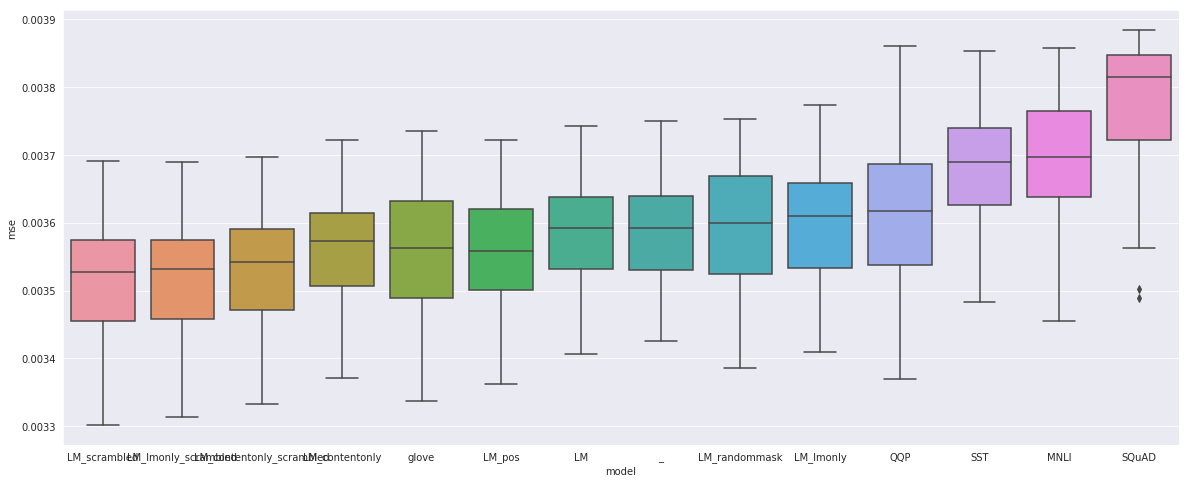

In [30]:
fig, ax = plt.subplots(figsize=(20, 8))
target_order = decoding_perfs.reset_index().groupby("model").mse.mean().argsort()
sns.boxplot(data=decoding_perfs.reset_index(), x="model", y="mse", order=target_order.index[target_order])

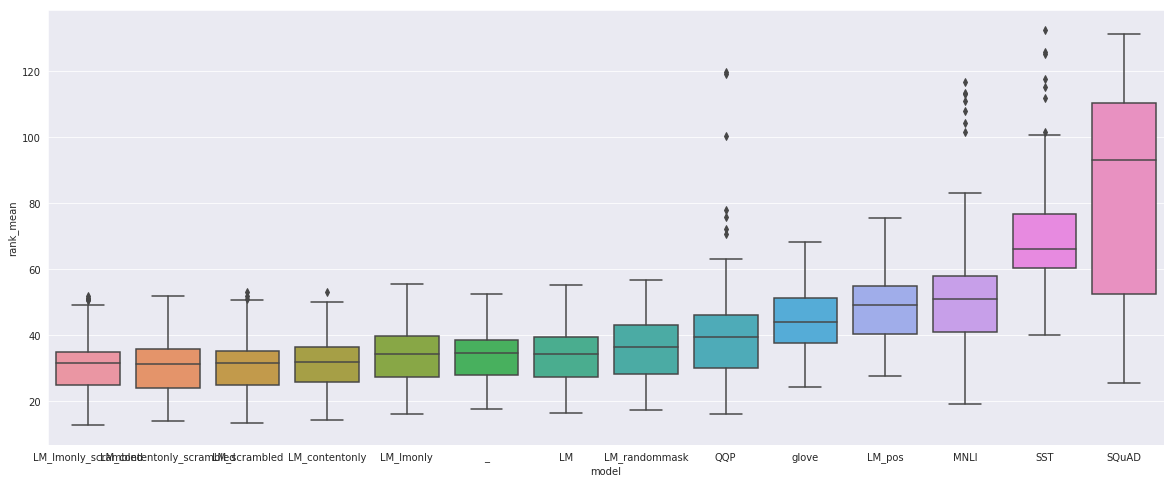

In [31]:
fig, ax = plt.subplots(figsize=(20, 8))
target_order = decoding_perfs.reset_index().groupby("model").rank_mean.mean().argsort()
sns.boxplot(data=decoding_perfs.reset_index(), x="model", y="rank_mean", order=target_order.index[target_order])

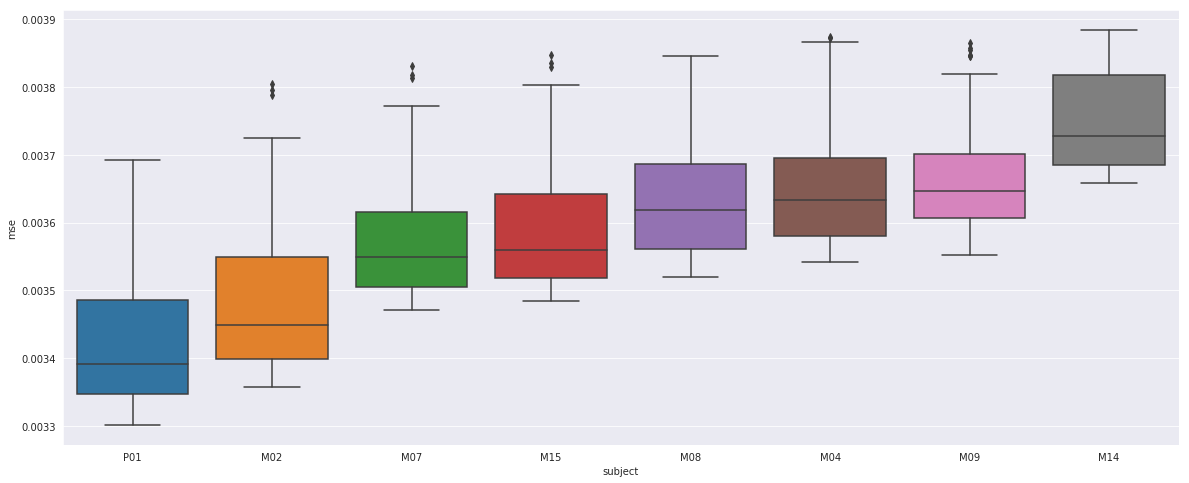

In [32]:
fig, ax = plt.subplots(figsize=(20, 8))
target_order = decoding_perfs.reset_index().groupby("subject").mse.mean().argsort()
sns.boxplot(data=decoding_perfs.reset_index(), x="subject", y="mse", order=target_order.index[target_order])

In [61]:
final_perfs = decoding_perfs.query("model == 'LM_scrambled' & step == %i" % checkpoint_steps[-1]) \
    .reset_index().groupby("subject").mean()
begin_perfs = decoding_perfs.query("model == '_'").reset_index().groupby("subject").mean().rename(columns=lambda c: "begin_%s" % c)
glove_perfs = decoding_perfs.query("model == 'glove'").reset_index().groupby("subject").mean().rename(columns=lambda c: "glove_%s" % c)

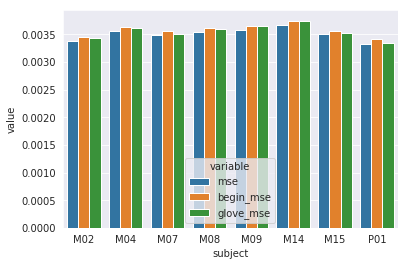

In [62]:
sns.barplot(data=final_perfs.join(begin_perfs).join(glove_perfs).reset_index().melt(id_vars=["subject"], value_vars=["mse", "begin_mse", "glove_mse"]),
            x="subject", y="value", hue="variable")

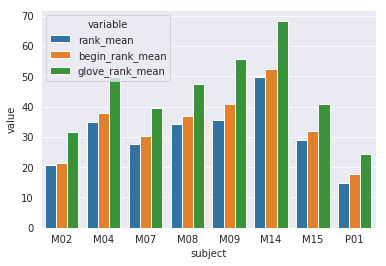

In [63]:
sns.barplot(data=final_perfs.join(begin_perfs).join(glove_perfs).reset_index().melt(id_vars=["subject"], value_vars=["rank_mean", "begin_rank_mean", "glove_rank_mean"]),
            x="subject", y="value", hue="variable")

### Statistical tests

In [69]:
comp = final_perfs.join(begin_perfs).join(glove_perfs)
st.ttest_rel(comp.mse, comp.glove_mse)

Ttest_relResult(statistic=-5.070942521395031, pvalue=0.0014455719147299128)

In [70]:
st.ttest_rel(comp.rank_mean, comp.glove_rank_mean)

Ttest_relResult(statistic=-10.585860444362948, pvalue=1.4681561790738606e-05)

In [71]:
st.ttest_rel(comp.rank_mean, comp.begin_rank_mean)

Ttest_relResult(statistic=-6.912641693967149, pvalue=0.00022871787337825573)